# Gamma ray spectrometry: energy resolution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
from scipy.optimize import curve_fit
from scipy.odr import unilinear, RealData, ODR
from scipy.interpolate import interp1d

In [2]:
peaks = pd.read_csv('final_peaks.csv')
peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy
0,Am241,17.055242,1.0,10.949870,1.0,26.3450,0.0010
1,Am241,48.949766,1.0,14.093629,1.0,59.5370,0.0010
2,Ba133,17.873519,1.0,11.895849,1.0,30.8507,0.0005
3,Ba133,67.937757,1.0,18.821271,2.0,80.9980,0.0080
4,Ba133,142.192815,2.0,39.449379,9.0,160.6050,0.0150
5,Ba133,275.049389,4.0,35.739316,18.0,302.8510,0.0150
6,Ba133,330.952029,1.0,43.324427,2.0,356.0050,0.0170
7,Co60,65.064552,1.0,25.459021,2.0,74.9690,0.0050
8,Co60,1081.715964,4.0,83.887352,15.0,1173.2080,0.0250
9,Co60,1226.627945,2.0,82.002000,16.0,1332.4910,0.0410


In [13]:
# used_energy = np.array([1408, 1275, 779, 662, 511, 344, 245, 122, 59.5])
# used_idx = np.any(np.abs(np.atleast_2d(peaks.energy) - np.atleast_2d(used_energy).T) < 1, axis=0)
# used_peaks = peaks[used_idx]
# used_peaks
used_peaks = peaks

In [14]:
df = pd.read_csv('calibration_parameters.csv')
params = df.beta.to_numpy()
delta_params = df.delta_beta.to_numpy()

In [15]:
resolution = params[0]*used_peaks.mean_widths/used_peaks.energy
delta_x = used_peaks.delta_energy/used_peaks.energy**2
delta_y = 2*resolution*((params[0]*used_peaks.width_deltas + delta_params[0]*used_peaks.mean_widths)/used_peaks.energy)

(delta_x/(1/used_peaks.energy)).mean(), (delta_y/resolution).mean()

(4.046131231571111e-05, 0.08018370736610299)

In [32]:
# neglect x errors compared to y errors, use ordinary least squares
def linear(x, slope, intercept):
    return slope*x + intercept

params, cov = curve_fit(
    linear, 1/used_peaks.energy, resolution**2, sigma=delta_y, absolute_sigma=True)
delta_params = np.sqrt(np.diag(cov))
fit_x = np.sort(1/used_peaks.energy)
fit = linear(fit_x, *params)
residuals = resolution**2 - linear(1/used_peaks.energy, *params)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((resolution**2 - np.mean(resolution**2))**2)

r_squared = 1 - ss_res/ss_tot

intrinsic_width = np.sqrt(params[1])
delta_intrinsic_width = delta_params[1]/(2*np.sqrt(params[1]))
print('W_I = {:.3f} +/- {:.3f}'.format(intrinsic_width, delta_intrinsic_width))

W_I = 0.035 +/- 0.004


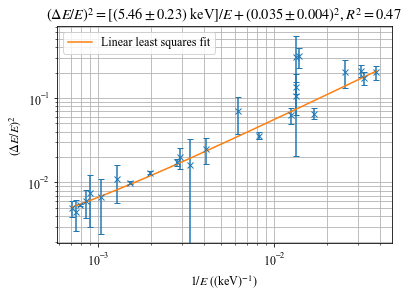

In [40]:
fig, ax = plt.subplots()
ax.errorbar(1/used_peaks.energy, resolution**2, yerr=delta_y, marker='x', linestyle='', capsize=3)
ax.plot(fit_x, fit, label='Linear least squares fit')
ax.grid(True, which='both')
title = (
    r'$(\Delta E/E)^2 = [({:.2f} \pm {:.2f})$ keV$]/E + ({:.3f} \pm {:.3f})^2, '
    r'R^2 = {:.2f}$'
).format(params[0], delta_params[0], intrinsic_width, delta_intrinsic_width, r_squared)
ax.set(xlabel=r'$1/E$ ((keV)$^{-1}$)', ylabel=r'$(\Delta E/E)^2$', title=title)
plt.xscale('log')
plt.yscale('log')
# fig.tight_layout()
ax.legend()
fig.savefig('figures/resolution.pdf', facecolor='w', bbox_inches='tight')